<h4> Импорт библиотек </h4>

In [16]:
import os
import re
import pandas as pd
import pymorphy2
from collections import defaultdict, Counter
import csv
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

Анализ тональности дискурса в группе с синдромом МКС (n=60)

In [9]:
# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

def load_rusentilex(filepath):
    """Загрузка словаря тональностей с учетом многозначности и контекста"""
    sentiment_lexicon = defaultdict(list)
    
    # Слова, которые всегда должны рассматриваться как факты
    FACT_WORDS = {
        'игрушка': 'fact',
        'смеяться': 'fact', 
        'щенок': 'fact',
        'зверь': 'fact'
    }
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            reader = csv.reader(f, delimiter=',')
            
            for row in reader:
                if not row or row[0].startswith('!'):
                    continue
                
                if len(row) >= 5:
                    ngram = row[2].lower().strip().split("/")[0]
                    
                    # Для слов из FACT_WORDS используем только записи с context='fact'
                    if ngram in FACT_WORDS:
                        if len(row) > 4 and row[4].strip().lower() == 'fact':
                            entry = {
                                'sentiment': row[3].strip().lower(),
                                'context': 'fact'
                            }
                            if len(row) > 5 and row[5].strip():
                                entry['additional'] = row[5].strip()
                            sentiment_lexicon[ngram].append(entry)
                        continue
                    
                    # Обычная обработка для остальных слов
                    context = row[4].strip().lower() if len(row) > 4 else 'fact'
                    
                    # Нормализация контекста
                    context_types = {
                        'opinion': 'opinion',
                        'feeling': 'feeling',
                        'fact': 'fact',
                        'оценка': 'opinion',
                        'мнение': 'opinion',
                        'чувство': 'feeling',
                        'эмоция': 'feeling'
                    }
                    context = context_types.get(context, 'fact')
                    
                    entry = {
                        'sentiment': row[3].strip().lower(),
                        'context': context
                    }
                    
                    if len(row) > 5 and row[5].strip():
                        entry['additional'] = row[5].strip()
                    
                    sentiment_lexicon[ngram].append(entry)
    except Exception as e:
        print(f"Ошибка загрузки словаря: {e}")
    
    return sentiment_lexicon

def resolve_ambiguity(entries):
    """Разрешение многозначности с учетом источника тональности"""
    if not entries:
        return None
    
    # Веса для разных типов тональности
    type_weights = {
        'opinion': 1.5,    # Наибольший вес для субъективных мнений
        'feeling': 1.3,    # Высокий вес для эмоциональных выражений
        'fact': 1.0        # Нейтральный вес для фактов
    }
    
    sentiment_counts = Counter()
    for entry in entries:
        sentiment = entry['sentiment']
        context_type = entry.get('context', 'fact').lower()
        
        # Применяем веса в зависимости от типа контекста
        weight = type_weights.get(context_type, 1.0)
        
        # Дополнительные модификаторы для разных типов тональности
        if sentiment in ['positive', 'negative']:
            weight *= 1.2
        elif sentiment == 'positive/negative':
            weight *= 1.1
            
        sentiment_counts[sentiment] += weight
    
    # Разрешаем многозначность
    emotional = [s for s in sentiment_counts]
    if emotional:
        return max(emotional, key=lambda x: sentiment_counts[x])
    
    return sentiment_counts.most_common(1)[0][0] if sentiment_counts else None

def read_text_file(filename):
    """Чтение текстового файла с обработкой разных кодировок"""
    encodings = ['utf-8', 'cp1251', 'iso-8859-1', 'koi8-r']
    for encoding in encodings:
        try:
            with open(filename, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            continue
    raise ValueError(f"Не удалось декодировать файл {filename}")

def clean_cha_text(text):
    """Очистка текста от служебных строк и меток"""
    # Регулярное выражение для удаления строк с метаданными
    # Удаляем строки, начинающиеся с '*INV:', '%mor:', '@', '=&'
    # Также удаляем строки с метками времени, например, '0_7219'
    cleaned_lines = []
    for line in text.split('\n'):
        # Удаляем пустые строки
        if not line.strip():
            continue
        # Проверяем, не начинается ли строка с служебных меток
        if line.startswith(('*INV:', '%mor:', '@', '=&')):
            continue
        # Удаляем метки времени
        cleaned_line = re.sub(r'\x15\d+_\d+\x15', '', line)
        # Удаляем оставшиеся служебные символы
        cleaned_line = re.sub(r'&\*=\w+', '', cleaned_line)
        # Добавляем очищенную строку, если она не пуста
        if cleaned_line.strip():
            cleaned_lines.append(cleaned_line.strip())
    # Объединяем все очищенные строки в единый текст
    return ' '.join(cleaned_lines)

def extract_dialogue(text):
    """Извлечение реплик из текста"""
    # Разбиваем текст на строки
    lines = text.split('\n')
    dialogue_lines = []
    for line in lines:
        # Удаляем все служебные метки и символы
        cleaned_line = re.sub(r'\*PAR:|&\*=\w+|\x15\d+_\d+\x15', '', line)
        cleaned_line = cleaned_line.strip()
        if cleaned_line:
            dialogue_lines.append(cleaned_line)
    # Объединяем все реплики в единый текст
    return ' '.join(dialogue_lines)

def remove_punctuation(word):
    """Удаление пунктуации из слова"""
    rus_punctuation = '«»—'
    all_punctuation = string.punctuation + rus_punctuation
    return word.translate(str.maketrans('', '', all_punctuation))

def lemmatize_text(text):
    """Лемматизация текста (возвращаем только леммы)"""
    cleaned_text = clean_cha_text(text)
    dialogue = extract_dialogue(cleaned_text)
    
    lemmatized = []
    
    # Извлекаем слова и удаляем пунктуацию
    words = re.findall(r'[А-яё\-]+', dialogue.lower())
    cleaned_words = [remove_punctuation(w) for w in words if remove_punctuation(w)]
    
    for word in cleaned_words:
        try:
            parsed = morph.parse(word)[0]
            lemma = parsed.normal_form if hasattr(parsed, 'normal_form') else word
            lemmatized.append(lemma)
        except Exception as e:
            lemmatized.append(word)
    
    return lemmatized

CONTEXT_RULES = {
    'не': 'invert',
    'ни': 'invert',
    'совсем не': 'invert',
    'очень': 'amplify',
    'крайне': 'amplify'
}

def apply_context_rules(words, i, lexicon):
    """Применение контекстных правил (инверсия, усиление)"""
    for ctx_len in [2, 1]:
        if i + ctx_len <= len(words):
            phrase = ' '.join(words[i:i+ctx_len])
            if phrase in CONTEXT_RULES:
                effect = CONTEXT_RULES[phrase]
                if i + ctx_len < len(words):
                    next_word = words[i+ctx_len]
                    if next_word in lexicon:
                        sentiment = resolve_ambiguity(lexicon[next_word])
                        if sentiment:
                            if effect == 'invert':
                                if sentiment == 'positive':
                                    return 'negative', ctx_len + 1
                                elif sentiment == 'negative':
                                    return 'positive', ctx_len + 1
                            elif effect == 'amplify':
                                return sentiment, ctx_len + 1
    return None, 0

def analyze_text(text, lexicon):
    """Анализ тональности текста с улучшенным учетом контекста"""
    words = lemmatize_text(text)
    sentiment_counts = Counter()
    matched_terms = defaultdict(list)
    used_indices = set()

    # Проверка четырехграмм
    for i in range(len(words) - 3):
        four_gram = ' '.join(words[i:i+4])
        if four_gram in lexicon:
            entries = lexicon[four_gram]
            sentiment = resolve_ambiguity(entries)
            if sentiment:
                sentiment_counts[sentiment] += 1
                matched_terms[sentiment].append(four_gram)
                used_indices.update(range(i, i + 4))  # Помечаем индексы как использованные

    # Проверка триграмм
    for i in range(len(words) - 2):
        three_gram = ' '.join(words[i:i+3])
        if three_gram in lexicon:
            entries = lexicon[three_gram]
            sentiment = resolve_ambiguity(entries)
            if sentiment:
                sentiment_counts[sentiment] += 1
                matched_terms[sentiment].append(three_gram)
                used_indices.update(range(i, i + 3))  # Помечаем индексы как использованные

    # Проверка биграмм
    for i in range(len(words) - 1):
        two_gram = ' '.join(words[i:i+2])
        if two_gram in lexicon:
            entries = lexicon[two_gram]
            sentiment = resolve_ambiguity(entries)
            if sentiment:
                sentiment_counts[sentiment] += 1
                matched_terms[sentiment].append(two_gram)
                used_indices.update(range(i, i + 2))  # Помечаем индексы как использованные

    # Проверка одиночных слов
    i = 0
    while i < len(words):
        if i in used_indices:
            i += 1
            continue
            
        word = words[i]
        
        # Проверяем контекстные правила
        sentiment, skip = apply_context_rules(words, i, lexicon)
        if sentiment is not None:
            sentiment_counts[sentiment] += 1
            matched_terms[sentiment].append(f"{' '.join(words[i:i+skip])}")
            for j in range(i, i + skip):
                used_indices.add(j)
            i += skip
            continue
            
        # Обычный анализ слова
        if word in lexicon:
            entries = lexicon[word]
            sentiment = resolve_ambiguity(entries)
            if sentiment:
                sentiment_counts[sentiment] += 1
                matched_terms[sentiment].append(word)
                used_indices.add(i)
        
        i += 1
    
    return sentiment_counts, matched_terms

def determine_sentiment(positive_count, negative_count, threshold=1):
    """Определение основного тона текста на основе количества позитивных и негативных слов."""
    if positive_count == negative_count:
        return 'neutral'
    elif abs(positive_count - negative_count) <= threshold:
        return 'neutral'
    elif positive_count > negative_count:
        return 'positive'
    else:
        return 'negative'  
    
def analyze_file(filepath, lexicon):
    """Анализ тональности файла с детализацией"""
    try:
        text = read_text_file(filepath)
        sentiment_counts, matched_terms = analyze_text(text, lexicon)
        
        if not sentiment_counts:
            result = {
                'filename': os.path.basename(filepath),
                'sentiment': 'neutral',
                'confidence': 0.0,
                'positive': 0,
                'negative': 0,
                'neutral': 0,
                'positive/negative': 0,
                'total_matched': 0,
                'matched_terms': '{}'
            }
        else:
            positive_count = sentiment_counts.get('positive', 0)
            negative_count = sentiment_counts.get('negative', 0)
            main_sentiment = determine_sentiment(positive_count, negative_count)
            total = sum(sentiment_counts.values())
            if main_sentiment == 'neutral':
                confidence = 0.5
            else:
                confidence = sentiment_counts[main_sentiment] / total if total != 0 else 0.0
            
            formatted_terms = {}
            for sentiment, terms in matched_terms.items():
                # Выводим все термины, разделенные запятыми
                formatted_terms[sentiment] = ', '.join(terms)
            
            result = {
                'filename': os.path.basename(filepath),
                'sentiment': main_sentiment,
                'confidence': round(confidence, 2),
                'positive': positive_count,
                'negative': negative_count,
                'neutral': sentiment_counts.get('neutral', 0),
                'positive/negative': sentiment_counts.get('positive/negative', 0),
                'total_matched': total,
                'matched_terms': str(formatted_terms)
            }
        
        return result
    
    except Exception as e:
        print(f"Ошибка обработки файла {filepath}: {e}")
        return None

def process_folder(folder_path, lexicon):
    """Обработка всех файлов в папке"""
    results = []
    
    if not os.path.exists(folder_path):
        print(f"Папка не существует: {folder_path}")
        return pd.DataFrame()
    
    files = [f for f in os.listdir(folder_path) if f.endswith('.cha')]
    for filename in tqdm(files, desc="Обработка файлов"):
        filepath = os.path.join(folder_path, filename)
        result = analyze_file(filepath, lexicon)
        if result:
            results.append(result)
    
    return pd.DataFrame(results)

if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Обработка папки с файлами
    folder_path = "MCI - данные"
    results_df = process_folder(folder_path, rusentilex)
    
    if not results_df.empty:
        # Сохранение результатов
        results_df.to_csv('sentiment_results.csv', index=False, encoding='utf-8-sig')
        
        print("\nРезультаты анализа тональности:")
        print("=" * 80)
        print(results_df[['filename', 'sentiment', 'confidence', 'positive', 'negative', 'neutral', 'positive/negative', 'total_matched']].to_string())
        
        print("\nПримеры найденных терминов:")
        print("=" * 80)
        for i, row in results_df.head(3).iterrows():
            print(f"\nФайл: {row['filename']}")
            print(f"Общий тон: {row['sentiment']} (уверенность: {row['confidence']})")
            print("Найденные термины:")
            print(row['matched_terms'])
        
        print("\nОбщая статистика:")
        print("=" * 80)
        print(f"Всего файлов: {len(results_df)}")
        print(f"Positive: {results_df['positive'].sum()}")
        print(f"Negative: {results_df['negative'].sum()}")
        print(f"Neutral: {results_df['neutral'].sum()}")
        print(f"Positive/Negative: {results_df['positive/negative'].sum()}")
        print(f"Всего тональных слов/фраз: {results_df['total_matched'].sum()}")
    else:
        print("Не удалось обработать файлы. Проверьте путь и формат файлов.")

Обработка файлов: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.22it/s]


Результаты анализа тональности:
         filename sentiment  confidence  positive  negative  neutral  positive/negative  total_matched
0      AA1010.cha  positive        1.00         4         0        0                  0              4
1      BB5946.cha   neutral        0.50         1         0        0                  0              1
2   BV2629_T3.cha   neutral        0.50         1         2        1                  0              4
3      CG5571.cha   neutral        0.50         1         1        0                  0              2
4      CH7346.cha  positive        1.00         4         0        0                  0              4
5      FM1911.cha  positive        1.00         5         0        0                  0              5
6      FQ3663.cha  positive        0.83        10         2        0                  0             12
7      FT5080.cha   neutral        0.50         5         5        0                  0             10
8   FU0873_T3.cha  positive        0.60 

In [5]:
# Проверка загрузки словаря
print("Проверка загрузки словаря:")
rusentilex = load_rusentilex('rusentilex_2017.csv')
if rusentilex:
    print("Словарь загружен успешно.")
    # Выводим первые 5 записей для проверки
    print("Примеры записей:")
    for i, (word, entries) in enumerate(rusentilex.items()):
        if i >= 5:
            break
        print(f"Слово: {word}")
        for entry in entries:
            print(f"  Тональность: {entry['sentiment']}, Контекст: {entry.get('context', 'fact')}")
else:
    print("Ошибка загрузки словаря.")

Проверка загрузки словаря:
Словарь загружен успешно.
Примеры записей:
Слово: аборт
  Тональность: negative, Контекст: fact
Слово: абортивный
  Тональность: negative, Контекст: fact
Слово: абракадабра
  Тональность: negative, Контекст: opinion
Слово: абсурд
  Тональность: negative, Контекст: opinion
Слово: абсурдность
  Тональность: negative, Контекст: opinion


In [17]:
# Проверка обработки текста
print("\nПроверка обработки текста:")
# Пример текста
example_text = """
@UTF8
@Window:	0_0_0_0_1222_1_1563_2_1563_2
@Begin
@Languages:	rus
@Participants:	PAR Participant, INV Investigator

@ID:	rus|BZ2902|PAR|||||Participant|||
@ID:	rus|BZ2902|INV|||||Investigator|||
@Media:	BZ2902, audio
*INV:	ну рассказывайте. 0_824
*PAR:	на мое &+шести шестидесятилетие &-ah (1.347) мой племянник подарил
	нам с мужем (0.488) поездку в Сочи.  824_10286
*PAR:	заказал отель &-eh (0.481) номер. 10659_12714
*PAR:	и (0.731) &-uh (0.859) ну <все> [/] все было очень хорошо. 12756_16146
*PAR:	и (0.724) &-ah (0.259) гостиница была прямо на берегу Черного моря. 16204_19756
*PAR:	это был март. 20193_21517
*PAR:	погода была прекрасная солнечная. 21761_24129
*PAR:	мы отдыхали гуляли &-ah_uh (4.598) брали экскурсии. 24632_33537
*PAR:	&-ну (0.668) в общем нам очень понравилось и настроение было на
	позитиве. 34478_38750
*PAR:	ну &+по погода иногда менялась &-но (1.114) это не портило вообще
	наше настроение было очень здорово. 39586_45344
*PAR:	и я им до сих пор очень благодарна. 45472_47225
*INV:	замечательно какой прекрасный племянник! 47310_49466
*INV:	а долго вы там были долго? 49574_51176
*PAR:	а мы там были &-ah_mm (1.591) где-то пять дней мы там были да да да.
	51219_56722
*PAR:	ну просто у нас детей с мужем нет а мои племянники я как бы с
	ними очень дружу. 56706_61118
*PAR:	прям я у них там Вера. 61178_62548
*PAR:	муж иногда ревнует. 62734_63825
*PAR:	&-и (0.476) мы дружим и они пытаются всегда мне как-то помочь там
	<его так> [//] (0.279) его настроение так немножко сгладить. 64287_71322
*PAR:	он такой немножко капризный у меня я его просто подизбаловала. 71316_74416
*PAR:	и &-и (1.765) они такие вещи некоторые берут на себя так чтобы все
	это сгладить и часто берут мужа одного там. 74834_82735
*PAR:	<они> [/] они любят Сочи &-и (1.509) отдыхать и хорошо знают (0.692)
	Сочи и берут его иногда с собой просто так.  82722_90530
*PAR:	учитывая его здоровье они как бы (0.395) присматривают за ним где
	&+по побыстрее идти где &+по помедленнее. 90635_96765
*PAR:	и &+е ему тоже очень нравится с ними отдыхать потому что как бы они
	&-mm (1.405) как это сказать следят за настроением даже так
	чтобы ничего +... 96717_104670
*INV:	психологическим. 105459_105912
*PAR:	да психологическим да так ага. 105982_107926
@End
"""
cleaned_text = clean_cha_text(example_text)
print("Очищенный текст:")
print(cleaned_text)

dialogue = extract_dialogue(cleaned_text)
print("\nИзвлеченные реплики:")
print(dialogue)

lemmatized = lemmatize_text(example_text)
print("\nЛемматизированный текст:")
print(lemmatized)


Проверка обработки текста:
Очищенный текст:
*PAR:	на мое &+шести шестидесятилетие &-ah (1.347) мой племянник подарил нам с мужем (0.488) поездку в Сочи. *PAR:	заказал отель &-eh (0.481) номер. *PAR:	и (0.731) &-uh (0.859) ну <все> [/] все было очень хорошо. *PAR:	и (0.724) &-ah (0.259) гостиница была прямо на берегу Черного моря. *PAR:	это был март. *PAR:	погода была прекрасная солнечная. *PAR:	мы отдыхали гуляли &-ah_uh (4.598) брали экскурсии. *PAR:	&-ну (0.668) в общем нам очень понравилось и настроение было на позитиве. *PAR:	ну &+по погода иногда менялась &-но (1.114) это не портило вообще наше настроение было очень здорово. *PAR:	и я им до сих пор очень благодарна. *PAR:	а мы там были &-ah_mm (1.591) где-то пять дней мы там были да да да. *PAR:	ну просто у нас детей с мужем нет а мои племянники я как бы с ними очень дружу. *PAR:	прям я у них там Вера. *PAR:	муж иногда ревнует. *PAR:	&-и (0.476) мы дружим и они пытаются всегда мне как-то помочь там <его так> [//] (0.279) его наст

Анализ тональности дискурсов в группе с синдромом МКС (n=100)

In [11]:
if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Обработка папки с файлами
    folder_path = "MCI - данные_100"
    results_df = process_folder(folder_path, rusentilex)
    
    if not results_df.empty:
        # Сохранение результатов
        results_df.to_csv('sentiment_results100.csv', index=False, encoding='utf-8-sig')
        
        print("\nРезультаты анализа тональности:")
        print("=" * 80)
        print(results_df[['filename', 'sentiment', 'confidence', 'positive', 'negative', 'neutral', 'positive/negative', 'total_matched']].to_string())
        
        print("\nПримеры найденных терминов:")
        print("=" * 80)
        for i, row in results_df.head(3).iterrows():
            print(f"\nФайл: {row['filename']}")
            print(f"Общий тон: {row['sentiment']} (уверенность: {row['confidence']})")
            print("Найденные термины:")
            print(row['matched_terms'])
        
        print("\nОбщая статистика:")
        print("=" * 80)
        print(f"Всего файлов: {len(results_df)}")
        print(f"Positive: {results_df['positive'].sum()}")
        print(f"Negative: {results_df['negative'].sum()}")
        print(f"Neutral: {results_df['neutral'].sum()}")
        print(f"Positive/Negative: {results_df['positive/negative'].sum()}")
        print(f"Всего тональных слов/фраз: {results_df['total_matched'].sum()}")
    else:
        print("Не удалось обработать файлы. Проверьте путь и формат файлов.")

Обработка файлов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.13it/s]


Результаты анализа тональности:
         filename sentiment  confidence  positive  negative  neutral  positive/negative  total_matched
0      AA1010.cha  positive        1.00         4         0        0                  0              4
1      BB5946.cha   neutral        0.50         1         0        0                  0              1
2   BN9025_T4.cha  positive        0.83         5         0        1                  0              6
3   BS8637_T4.cha   neutral        0.00         0         0        0                  0              0
4   BV2629_T3.cha   neutral        0.50         1         2        1                  0              4
5      BZ2902.cha  positive        0.80        12         2        1                  0             15
6      CG5571.cha   neutral        0.50         1         1        0                  0              2
7      CH7346.cha  positive        1.00         4         0        0                  0              4
8      CW0090.cha  positive        0.90 

Анализ тональности дискурса в контрольной группе (n=60)

In [12]:
if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Обработка папки с файлами
    folder_path = "Контроль-группа данные"
    results_df = process_folder(folder_path, rusentilex)
    
    if not results_df.empty:
        # Сохранение результатов
        results_df.to_csv('sentiment_results_control60.csv', index=False, encoding='utf-8-sig')
        
        print("\nРезультаты анализа тональности:")
        print("=" * 80)
        print(results_df[['filename', 'sentiment', 'confidence', 'positive', 'negative', 'neutral', 'positive/negative', 'total_matched']].to_string())
        
        print("\nПримеры найденных терминов:")
        print("=" * 80)
        for i, row in results_df.head(3).iterrows():
            print(f"\nФайл: {row['filename']}")
            print(f"Общий тон: {row['sentiment']} (уверенность: {row['confidence']})")
            print("Найденные термины:")
            print(row['matched_terms'])
        
        print("\nОбщая статистика:")
        print("=" * 80)
        print(f"Всего файлов: {len(results_df)}")
        print(f"Positive: {results_df['positive'].sum()}")
        print(f"Negative: {results_df['negative'].sum()}")
        print(f"Neutral: {results_df['neutral'].sum()}")
        print(f"Positive/Negative: {results_df['positive/negative'].sum()}")
        print(f"Всего тональных слов/фраз: {results_df['total_matched'].sum()}")
    else:
        print("Не удалось обработать файлы. Проверьте путь и формат файлов.")

Обработка файлов: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.06it/s]


Результаты анализа тональности:
         filename sentiment  confidence  positive  negative  neutral  positive/negative  total_matched
0      AB4388.cha  positive        0.93        14         0        1                  0             15
1      AF3766.cha   neutral        0.50         0         1        0                  0              1
2      AO0296.cha   neutral        0.50         3         2        6                  0             11
3   AT2501_T4.cha  positive        0.61        14         6        3                  0             23
4      BJ9939.cha  positive        0.46         6         2        5                  0             13
5      CP8082.cha   neutral        0.50         2         3        0                  0              5
6      CY9104.cha  positive        0.77        10         2        1                  0             13
7      DB7393.cha   neutral        0.50         1         0        0                  0              1
8      EE5407.cha   neutral        0.50 

Анализ тональности дискурса в контрольной группе (n=100)

In [13]:
if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Обработка папки с файлами
    folder_path = "Контроль-группа данные_100"
    results_df = process_folder(folder_path, rusentilex)
    
    if not results_df.empty:
        # Сохранение результатов
        results_df.to_csv('sentiment_results_control100.csv', index=False, encoding='utf-8-sig')
        
        print("\nРезультаты анализа тональности:")
        print("=" * 80)
        print(results_df[['filename', 'sentiment', 'confidence', 'positive', 'negative', 'neutral', 'positive/negative', 'total_matched']].to_string())
        
        print("\nПримеры найденных терминов:")
        print("=" * 80)
        for i, row in results_df.head(3).iterrows():
            print(f"\nФайл: {row['filename']}")
            print(f"Общий тон: {row['sentiment']} (уверенность: {row['confidence']})")
            print("Найденные термины:")
            print(row['matched_terms'])
        
        print("\nОбщая статистика:")
        print("=" * 80)
        print(f"Всего файлов: {len(results_df)}")
        print(f"Positive: {results_df['positive'].sum()}")
        print(f"Negative: {results_df['negative'].sum()}")
        print(f"Neutral: {results_df['neutral'].sum()}")
        print(f"Positive/Negative: {results_df['positive/negative'].sum()}")
        print(f"Всего тональных слов/фраз: {results_df['total_matched'].sum()}")
    else:
        print("Не удалось обработать файлы. Проверьте путь и формат файлов.")

Обработка файлов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.44it/s]


Результаты анализа тональности:
         filename sentiment  confidence  positive  negative  neutral  positive/negative  total_matched
0      AB4388.cha  positive        0.93        14         0        1                  0             15
1      AF3766.cha   neutral        0.50         0         1        0                  0              1
2      AK6922.cha  positive        0.55         6         2        3                  0             11
3      AO0296.cha   neutral        0.50         3         2        6                  0             11
4   AT2501_T4.cha  positive        0.61        14         6        3                  0             23
5   BC2506_T4.cha  positive        0.82         9         1        1                  0             11
6      BJ9939.cha  positive        0.46         6         2        5                  0             13
7      BU5973.cha   neutral        0.50         2         1        1                  0              4
8      BZ3684.cha   neutral        0.50 

Статистический анализ по группам и визуализация результатов:


            Анализ групп по 60 человек            


Обработка файлов: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.59it/s]



           Анализ групп по 100 человек            


Обработка файлов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.45it/s]



        Сводная статистика по всем группам        


sentiment,Отрицательные,Нейтральные,Положительные
group,,,
MCI (n=100),2,25,73
MCI (n=60),1,16,43
Контроль (n=100),3,25,72
Контроль (n=60),2,17,41



Средние показатели по группам:


,positive,negative,neutral,total_matched
group,,,,
MCI (n=100),4.440000,0.890000,0.830000,6.190000
MCI (n=60),4.270000,0.950000,0.680000,5.930000
Контроль (n=100),6.160000,1.430000,1.350000,8.940000
Контроль (n=60),6.650000,1.680000,1.500000,9.830000


/tmp/ipykernel_190/2885225951.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_all, x='group', y='total_matched',


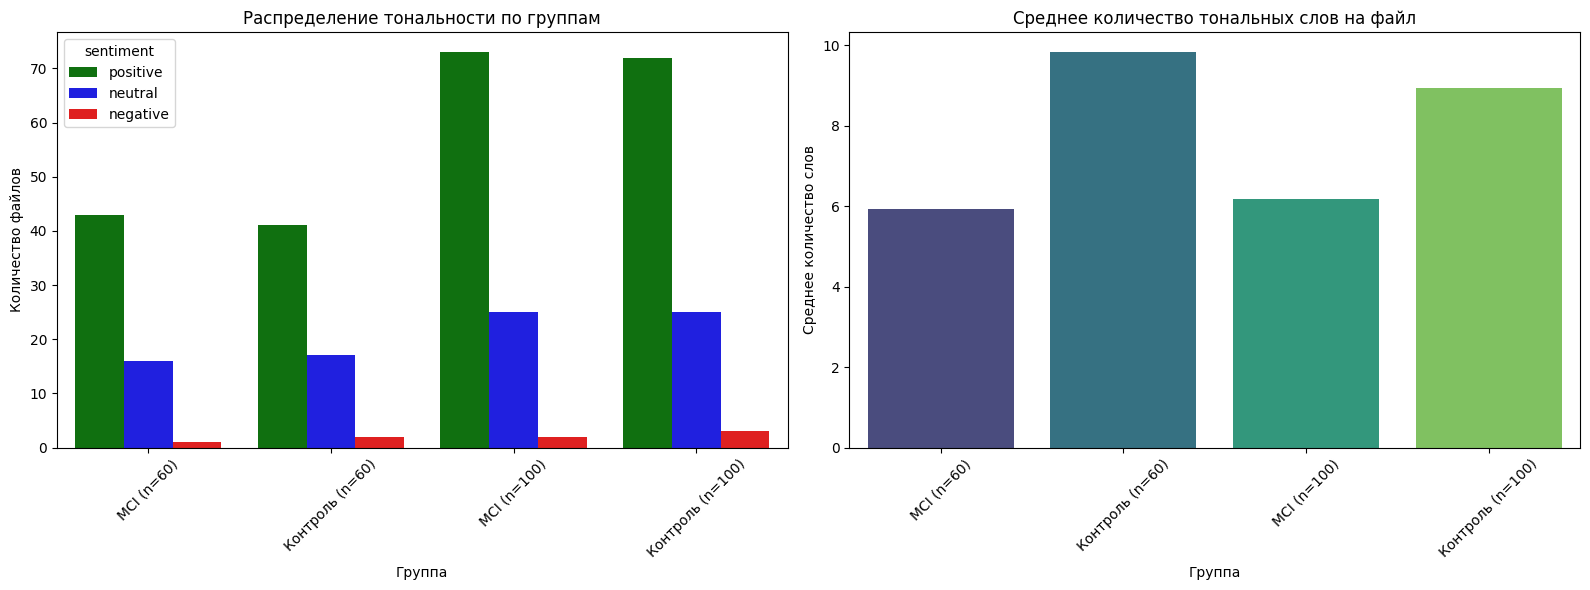

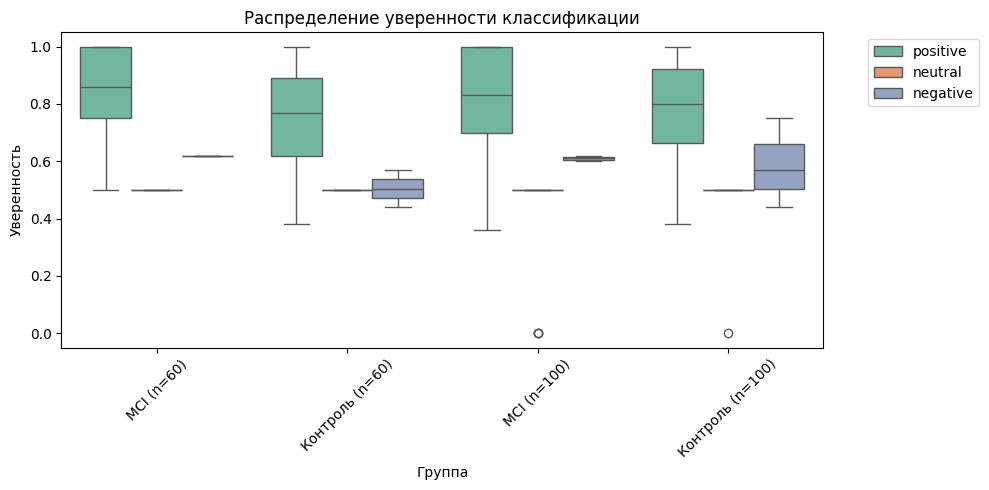

In [14]:
def analyze_and_visualize_groups(lexicon):
    """Анализирует все группы и выводит таблицы и графики"""
    
    # 1. Анализ групп по 60 человек
    print("\n" + "="*50)
    print("Анализ групп по 60 человек".center(50))
    print("="*50)
    
    mci_60 = process_folder("MCI - данные", lexicon)
    control_60 = process_folder("Контроль-группа данные", lexicon)
    
    # Добавляем метки групп
    if not mci_60.empty:
        mci_60['group'] = 'MCI (n=60)'
    if not control_60.empty:
        control_60['group'] = 'Контроль (n=60)'
    
    # Объединяем результаты
    df_60 = pd.concat([mci_60, control_60])
    
    # 2. Анализ групп по 100 человек
    print("\n" + "="*50)
    print("Анализ групп по 100 человек".center(50))
    print("="*50)
    
    mci_100 = process_folder("MCI - данные_100", lexicon)
    control_100 = process_folder("Контроль-группа данные_100", lexicon)
    
    # Добавляем метки групп
    if not mci_100.empty:
        mci_100['group'] = 'MCI (n=100)'
    if not control_100.empty:
        control_100['group'] = 'Контроль (n=100)'
    
    # Объединяем все результаты
    df_all = pd.concat([df_60, mci_100, control_100])
    
    if df_all.empty:
        print("Нет данных для анализа")
        return
    
    # 3. Создаем сводные таблицы
    print("\n" + "="*50)
    print("Сводная статистика по всем группам".center(50))
    print("="*50)
    
    # Таблица 1: Количество файлов по тональности
    summary_table = pd.pivot_table(
        df_all, 
        index='group', 
        columns='sentiment', 
        values='filename', 
        aggfunc='count',
        fill_value=0
    )
    
    # Переименовываем столбцы для красоты
    summary_table = summary_table.rename(columns={
        'positive': 'Положительные',
        'negative': 'Отрицательные',
        'neutral': 'Нейтральные'
    })
    
    display(summary_table.style.background_gradient(cmap='Blues'))
    
    # Таблица 2: Средние значения показателей
    stats_table = df_all.groupby('group').agg({
        'positive': 'mean',
        'negative': 'mean', 
        'neutral': 'mean',
        'total_matched': 'mean'
    }).round(2)
    
    print("\nСредние показатели по группам:")
    display(stats_table.style.background_gradient(cmap='Greens'))
    
    # 4. Строим графики сравнения
    plt.figure(figsize=(16, 6))
    
    # График 1: Распределение тональности
    plt.subplot(1, 2, 1)
    sns.countplot(data=df_all, x='group', hue='sentiment', 
                 palette={'positive': 'green', 'negative': 'red', 'neutral': 'blue'})
    plt.title('Распределение тональности по группам')
    plt.xlabel('Группа')
    plt.ylabel('Количество файлов')
    plt.xticks(rotation=45)
    
    # График 2: Среднее количество тональных слов
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_all, x='group', y='total_matched', 
               estimator='mean', errorbar=None, palette='viridis')
    plt.title('Среднее количество тональных слов на файл')
    plt.xlabel('Группа')
    plt.ylabel('Среднее количество слов')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Дополнительный анализ: распределение confidence
    if 'confidence' in df_all.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_all, x='group', y='confidence', 
                   hue='sentiment', palette='Set2')
        plt.title('Распределение уверенности классификации')
        plt.xlabel('Группа')
        plt.ylabel('Уверенность')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Анализ и визуализация всех групп
    analyze_and_visualize_groups(rusentilex)

Обработка файлов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.44it/s]



Сводная статистика по группам:
              group  total_files  positive  negative  neutral
0        MCI (n=60)           60        43         1       16
1   Контроль (n=60)           60        41         2       17
2       MCI (n=100)          100        73         2       25
3  Контроль (n=100)          100        72         3       25


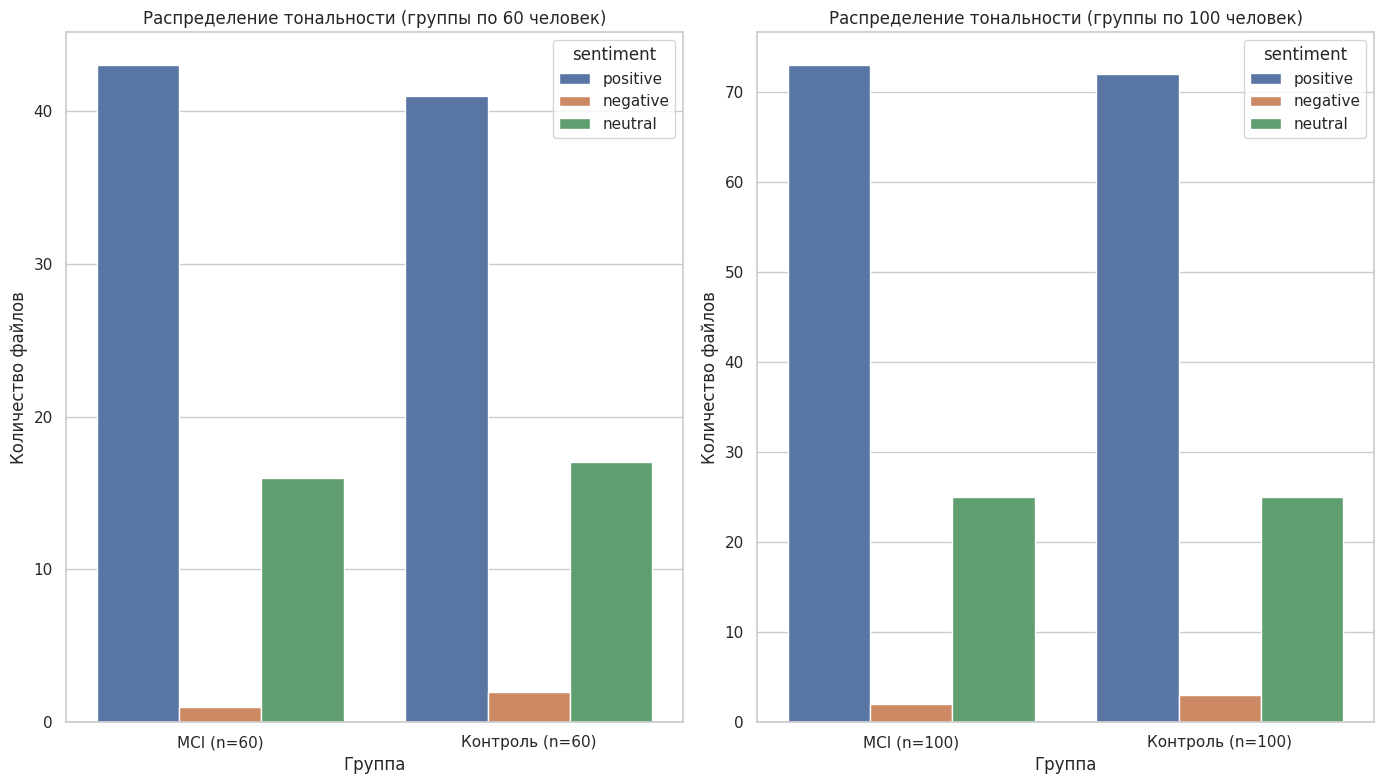

In [15]:
# Функция для анализа папки и создания сводной статистики
def analyze_group(folder_path, lexicon, group_name):
    df = process_folder(folder_path, lexicon)
    if df.empty:
        return None
    
    # Сводная статистика по тональности
    sentiment_counts = df['sentiment'].value_counts().to_dict()
    
    return {
        'group': group_name,
        'total_files': len(df),
        'positive': sentiment_counts.get('positive', 0),
        'negative': sentiment_counts.get('negative', 0),
        'neutral': sentiment_counts.get('neutral', 0),
    }

# Основная функция для сравнения групп
def compare_groups(lexicon):
    # Анализ групп по 60 человек
    mci_60 = analyze_group("MCI - данные", lexicon, "MCI (n=60)")
    control_60 = analyze_group("Контроль-группа данные", lexicon, "Контроль (n=60)")
    
    # Анализ групп по 100 человек
    mci_100 = analyze_group("MCI - данные_100", lexicon, "MCI (n=100)")
    control_100 = analyze_group("Контроль-группа данные_100", lexicon, "Контроль (n=100)")
    
    # Создаем сводную таблицу
    results = []
    for data in [mci_60, control_60, mci_100, control_100]:
        if data:
            results.append(data)
    
    summary_df = pd.DataFrame(results)
    
    # Сохраняем результаты
    summary_df.to_csv('sentiment_summary.csv', index=False, encoding='utf-8-sig')
    print("\nСводная статистика по группам:")
    print(summary_df)
    
    # Визуализация результатов
    plot_results(summary_df)

# Функция для визуализации результатов
def plot_results(summary_df):
    # Подготовка данных для графиков
    plot_data = pd.melt(summary_df, id_vars=['group'], 
                        value_vars=['positive', 'negative', 'neutral'],
                        var_name='sentiment', value_name='count')
    
    # Настройка стиля графиков
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 8))
    
    # График для групп по 60 человек
    plt.subplot(1, 2, 1)
    data_60 = plot_data[plot_data['group'].str.contains('n=60')]
    if not data_60.empty:
        sns.barplot(x='group', y='count', hue='sentiment', data=data_60)
        plt.title('Распределение тональности (группы по 60 человек)')
        plt.ylabel('Количество файлов')
        plt.xlabel('Группа')
    
    # График для групп по 100 человек
    plt.subplot(1, 2, 2)
    data_100 = plot_data[plot_data['group'].str.contains('n=100')]
    if not data_100.empty:
        sns.barplot(x='group', y='count', hue='sentiment', data=data_100)
        plt.title('Распределение тональности (группы по 100 человек)')
        plt.ylabel('Количество файлов')
        plt.xlabel('Группа')
    
    plt.tight_layout()
    plt.savefig('sentiment_comparison.png')
    plt.show()

if __name__ == "__main__":
    # Загрузка словаря тональностей
    rusentilex = load_rusentilex('rusentilex_2017.csv')
    
    # Сравнение групп
    compare_groups(rusentilex)